In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [21]:
# Tạo Autoencoder (Purifier)
def create_autoencoder(input_shape):
    # Encoder
    input_layer = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.Dense(64, activation='relu')(x)
    encoded = layers.Dense(32, activation='relu')(x)

    # Decoder
    x = layers.Dense(64, activation='relu')(encoded)
    x = layers.Dense(128, activation='relu')(x)
    decoded = layers.Dense(input_shape[0], activation='softmax')(x)  # Tái tạo lại logits

    # Tạo Autoencoder
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return autoencoder

In [22]:
# Tạo Inversion Model
def create_inversion_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    reconstructed_input = layers.Dense(28 * 28, activation='sigmoid')(x)
    reconstructed_input = layers.Reshape((28, 28, 1))(reconstructed_input)  # Tái tạo ảnh

    inversion_model = models.Model(input_layer, reconstructed_input)
    inversion_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return inversion_model

In [23]:
def train_with_ppf(cnn_model, autoencoder, inversion_model, x_train, y_train, epochs, batch_size):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Lưu lịch sử huấn luyện

    for epoch in range(epochs):
        # Huấn luyện Autoencoder (Purifier) với logits
        logits = cnn_model.predict(x_train, batch_size=batch_size)
        autoencoder_loss = autoencoder.train_on_batch(logits, logits)

        # Huấn luyện Inversion Model (tái tạo lại đầu vào từ logits)
        inversion_model_loss = inversion_model.train_on_batch(logits, x_train)

        # Huấn luyện CNN (Mô hình mục tiêu) với dữ liệu gốc
        cnn_loss, cnn_acc = cnn_model.train_on_batch(x_train, y_train)

        # Lưu lại kết quả của mỗi epoch
        history['loss'].append(cnn_loss)
        history['accuracy'].append(cnn_acc)

        # Cập nhật validation loss và accuracy
        val_loss, val_acc = cnn_model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Autoencoder Loss: {autoencoder_loss}")
        print(f"Inversion Model Loss: {inversion_model_loss}")
        print(f"CNN Loss: {cnn_loss}, CNN Accuracy: {cnn_acc}")

    return history, cnn_model, autoencoder, inversion_model


In [24]:
# Build the model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_nn():
  model = Sequential([
      Flatten(input_shape=(28, 28, 1)),
      Dense(128, activation='relu'),
      Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [25]:
def create_cnn():
  model = Sequential([
      layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D(pool_size=2),
      layers.Conv2D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling2D(pool_size=2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(10, activation='softmax') # Đây là logits mà chúng ta muốn purifier
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [26]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [27]:
victim_epochs = 30
victim_batch_size = 128

## Simple_CNN

In [28]:
# Create Simple CNN model
simple_nn_model = create_simple_nn()
autoencoder = create_autoencoder((10,))  # Logits có dạng (batch_size, 10)
inversion_model = create_inversion_model((10,))

In [29]:
history_simple_nn_model, simple_nn_model, autoencoder, inversion_model = train_with_ppf(
    simple_nn_model, autoencoder, inversion_model, x_train, y_train, epochs= victim_epochs, batch_size= victim_batch_size)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/30
Autoencoder Loss: [array(2.302884, dtype=float32), array(0.05191667, dtype=float32)]
Inversion Model Loss: [array(0.23136854, dtype=float32), array(0.39275068, dtype=float32)]
CNN Loss: 2.3561973571777344, CNN Accuracy: 0.10266666859388351
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 2/30
Autoencoder Loss: [array(2.3024473, dtype=float32), array(0.12708333, dtype=float32)]
Inversion Model Loss: [array(0.23103358, dtype=float32), array(0.45398933, dtype=float32)]
CNN Loss: 2.2125837802886963, CNN Accuracy: 0.20328333973884583
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3/30
Autoencoder Loss: [array(2.3022273, dtype=float32), array(0.13137777, dtype=float32)]
Inversion Model Loss: [array(0.23066545, dtype=float32), array(0.5047655, dtype=float32)]
CNN Loss: 2.0821590423583984, CNN Accuracy: 0.3521333336830139
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 4/30
Autoencoder Loss: [array(2.3021052, dtype=float32), array(0.16029583, dt

In [30]:
simple_nn_model.save("./PPF/victim_simple_cnn_model.keras")

In [31]:
loss, acc = simple_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8602 - loss: 0.5318
Victim Model Accuracy On Test Set: 87.78%


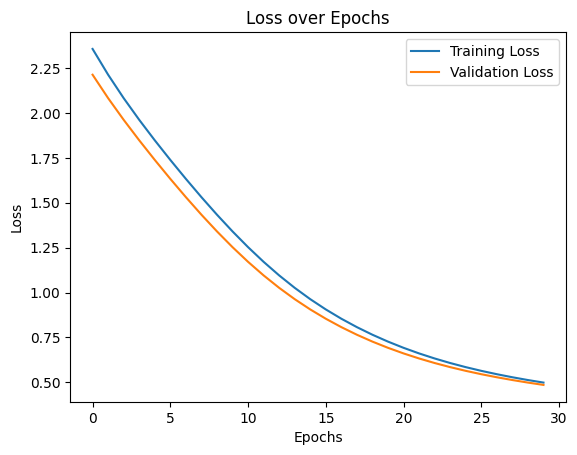

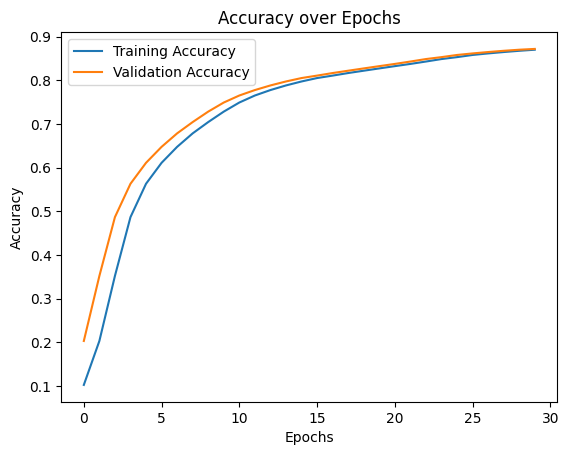

In [32]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_simple_nn_model['loss'], label='Training Loss')
plt.plot(history_simple_nn_model['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_simple_nn_model['accuracy'], label='Training Accuracy')
plt.plot(history_simple_nn_model['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Convolutional CNN

In [33]:
# Define victim model
c_nn_model = create_cnn()
autoencoder = create_autoencoder((10,))  # Logits có dạng (batch_size, 10)
inversion_model = create_inversion_model((10,))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train victim model
history_c_nn_model, c_nn_model, autoencoder, inversion_model = train_with_ppf(
    c_nn_model, autoencoder, inversion_model, x_train, y_train, epochs=10, batch_size=128)

469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Epoch 1/10
Autoencoder Loss: [array(2.302365, dtype=float32), array(0.0503, dtype=float32)]
Inversion Model Loss: [array(0.23127215, dtype=float32), array(0.4265492, dtype=float32)]
CNN Loss: 2.3043928146362305, CNN Accuracy: 0.08758333325386047
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [ ]:
c_nn_model.save("./PPF/victim_cnn_model.keras")

In [ ]:
# Evaluate victim model
loss, acc = c_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9874 - loss: 0.0416
Victim Model Accuracy On Test Set: 99.02%


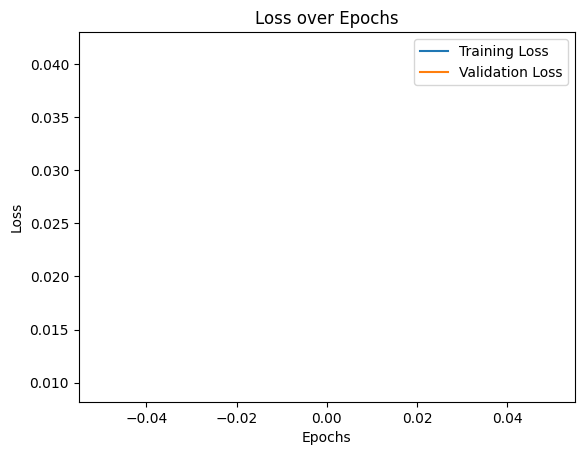

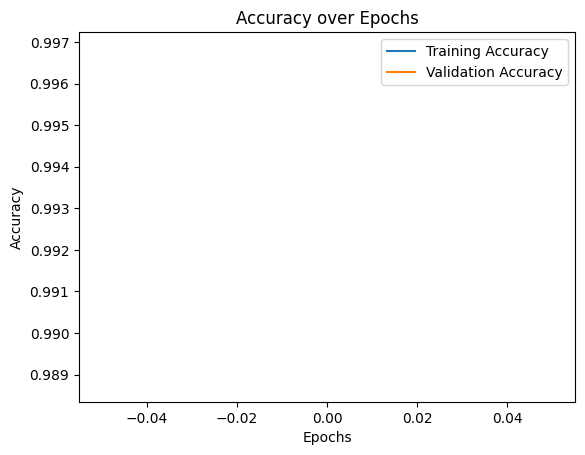

In [ ]:
# Accessing and Displaying Training History
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_c_nn_model.history['loss'], label='Training Loss')
plt.plot(history_c_nn_model.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_c_nn_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_c_nn_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()